# Creating custom MDP problems in MDPax

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joefarrington/mdpax/blob/main/examples/create_custom_problem.ipynb)


This tutorial shows how to implement your own Markov Decision Process (MDP) problems using MDPax. We'll implement the classic FrozenLake environment, which is a well-known example from [OpenAI's Gym/Gymnasium](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

## Prerequisites

Before getting started, you might find these resources helpful if you're unfamiliar with either JAX or MDPs. 

### JAX Background

- [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
- [JAX Tutorial](https://jax.readthedocs.io/en/latest/jax-101/index.html)
- 📺 [Machine Learning with JAX - From Zero to Hero | Aleksa Gordić](https://www.youtube.com/watch?v=SstuvS-tVc0)

### MDP Background

- [Reinforcement Learning: An Introduction - Chapter 3 | Sutton & Barto](http://incompleteideas.net/book/RLbook2020.pdf)
- 📺 [Markov Decision Processes 1 - Value Iteration | Stanford CS221](https://www.youtube.com/watch?v=9g32v7bK3Co)


## MDPax Problem class

The `Problem` class is used to represent MDPs in MDPax. As described in the [Getting Started] notebook, it uses a functional approach to describe the MDP instead of explicitly creating transition and reward matrices. 

When creating a subclass of `Problem` to represent your own MDP, you will need to define an `__init__` method and the following methods marked as `@abstractmethods` in the `Problem` class:

* `name`: A unique string identifier for the MDP
* `_construct_state_space`: A helper function that builds an array of all possible states, with dimensions [n_states, state_dim]
* `state_to_index`: A function that maps from a state vector to its index in the state space array
* `_construct_action_space`: A helper function that builds an array of all possible actions, with dimensions [n_actions, action_dim]
* `_construct_random_event_space`: A helper function that builds an array of all possible random events, with dimensions [n_events, event_dim]
* `random_event_probability`: A function that returns the probability of a random event given a state and action
* `transition`: A function that returns the next state and reward given a state, action, and random event. 

See the MDPax documentation [LINK TO DO] for detailed information about the `Problem` class.

In this notebook we'll walk through implementing each of those methods for the FrozenLake problem. 

## FrozenLake

In FrozenLake, an agent must navigate from start (S) to goal (G) on a frozen lake surface (F), avoiding holes in the ice (H).

The default 4x4 map looks like this:
```
SFFF
FHFH
FFFH
HFFG
``` 

The surface can be slippery, making movement stochastic: when the agent chooses a direction, they may instead slide perpendicular to their intended direction.

In [1]:
import sys

try:
    # Other dependencies will be installed on Colab already
    import mdptoolbox

    import mdpax
except ImportError:
    if 'google.colab' in sys.modules:
        # Automatically install mdpax if running in Colab, environment is temporary
        !pip install mdpax mdptoolbox matplotlib
    else:
        print("Dependencies not installed. Please follow the installation instructions in the README: https://github.com/joefarrington/mdpax")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mdptoolbox
import numpy as np

from mdpax.core.problem import Problem
from mdpax.utils.spaces import create_range_space
from mdpax.utils.types import (
    ActionSpace,
    ActionVector,
    Policy,
    RandomEventSpace,
    RandomEventVector,
    Reward,
    StateSpace,
    StateVector,
)

## 1 Step-by-step Problem definition

First, we'll create our `FrozenLake` class that inherits from `mdpax.core.problem.Problem`. 
The base class handles much of the boilerplate, we just need to implement the required methods.

In order to avoid duplication in the notebook, each part of the step-by-step definition inherits from the previous one, building up the class definition. All the cells in Part 1 therefore need to be run in order. To see the full class definition rather than working through the methods one by one you can skip ahead to [Part 2](##-2-Putting-it-all-together). 

### 1.1 The `__init__` method and config class

We'll start with an outline of the class, with a placeholder for each method, and fill in the `__init__` method. We use some custom types in the function signature, which are defined in [mdpax/utils/typing][LINK TO DO]. 

Following the `gym` implementation, we need to support three arguments:
* `desc`: A custom map
* `map_name`: A key for a map in the dictionary of known maps `MAPS`
* `is_slippery`: Whether the lake is slippery or not

We'll comment out `super().__init__()` for now because it performs some setup procedures that rely on all the methods being defined and we are implementing them one by one.

In [3]:
# Dictionary of known maps
# From https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ],
}

In [4]:
class FrozenLake(Problem):
    """FrozenLake MDP from OpenAI Gym.

    Models navigation on a grid world with slippery movement.
    
    The agent must navigate from start (S) to goal (G) on a frozen lake surface (F)
    where the surface is slippery and there are holes (H) that end the episode. 
    
    Example 4x4 map:
    SFFF
    FHFH
    FFFH
    HFFG

    State Space (state_dim = 2):
        Vector containing:
        - Row: 1 element in range [0, n_rows-1]
        - Column: 1 element in range [0, n_cols-1]

    Action Space (action_dim = 1):
        Vector containing:
        - Intended movement direction: 1 element in range [0, 3]
            where:
            - 0: LEFT
            - 1: DOWN
            - 2: RIGHT
            - 3: UP

    Random Events (event_dim = 1):
        Vector containing:
        - Actual movement direction: 1 element in range [0, 3]

    Dynamics:
        1. The agent chooses an intended movement direction
        2. The agent moves in the actual direction.
            - If the surface is not slippery, the agent moves in the intended direction.
            - If the surface is slippery, the agent has a 1/3 probability of moving
                in the intended direction, a 1/3 probability of moving in the 
                direction to the left of the intended direction, and a 1/3 
                probability of moving in the direction to the right of the intended 
                direction.
        3. The episode ends when the agent reaches the goal or falls into a hole
    
    Args:
        desc: Custom map layout as list of strings
        map_name: Key for a map in the dictionary of known maps `MAPS`
        is_slippery: If True, the movement direction is stochastic
    """
    def __init__(
        self, 
        desc: list[str] | None = None,
        map_name: str = "4x4",
        is_slippery: bool = True,
    ):
        self.desc = desc
        self.map_name = map_name
        self.is_slippery = is_slippery

        # Use a custom map if provided
        if desc is not None:
            self.map = desc
        else:
            self.map = MAPS[map_name]

        # Convert map to array for efficient lookup
        # Needs to be numeric so use 1 for hole and 2 for goal
        # 0 for frozen surface
        self.grid = jnp.array([
            [1 if c == 'H' else 2 if c == 'G' else 0 
             for c in row]
            for row in self.map
        ])
        self.n_rows, self.n_cols = self.grid.shape
        
        # This relies on all the methods being defined, so
        # comment out until class complete
        #super().__init__()
    
    @property
    def name(self) -> str:
        """Unique identifier for this problem type."""
        pass
    
    def _construct_state_space(self) -> StateSpace:
        """Build array of all possible states.

        Returns:
            Array of shape [n_states, state_dim] containing all possible states
        """
        pass

    def state_to_index(self, state: StateVector) -> int:
        """Convert state vector to index.

        Args:
            state: Vector representation of a state [state_dim]

        Returns:
            Index of the state in state_space

        Note:
            This mapping must be consistent with the ordering in state_space
        """
        pass
    
    def _construct_action_space(self) -> ActionSpace:
        """Build an array of all possible actions.

        Returns:
            Array of shape [n_actions, action_dim] containing all possible actions
        """
        pass
    
    def _construct_random_event_space(self) -> RandomEventSpace:
        """Build an array of all possible random events.

        Returns:
            Array of shape [n_events, event_dim] containing all possible random events
        """
        pass
    
    def random_event_probability(
        self,
        state: StateVector,
        action: ActionVector,
        random_event: RandomEventVector
    ) -> float:
        """Calculate probability of random event given state-action pair.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Probability of the random event occurring
        """
        pass

    def transition(
    self,
    state: StateVector,
    action: ActionVector,
    random_event: RandomEventVector
    ) -> tuple[StateVector, Reward]:
        """Compute next state and reward for a transition.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Tuple containing the next state vector [state_dim] and
            the immediate reward
        """
        pass

Now we can create an instance using the 4x4 map with slippery movement:

In [5]:
problem = FrozenLake(map_name="4x4", is_slippery=True)

In [6]:
problem.grid

Array([[0, 0, 0, 0],
       [0, 1, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 2]], dtype=int32)

### 1.2 The `name` property

The `name` property is used to set a checkpoint directory when one is not provided. It can therefore be a name for any problem represented by the class or, as here, provide some information about the input settings.

In [7]:
class FrozenLake(FrozenLake):
    @property
    def name(self) -> str:
        """Unique identifier for this problem type."""
        s = "slippery" if self.is_slippery else "non_slippery"
        if self.desc is not None:
            return f"frozen_lake_custom_{s}"
        else:
            return f"frozen_lake_{self.map_name}_{s}"

In [8]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
problem.name

'frozen_lake_4x4_slippery'

### 1.3 The `_construct_state_space` and `state_to_index` methods

In MDPax, the `state_space` for a problem is a 2D array that contains every possible state for the MDP. Each row is a vector representing one state. This helper method is called when the class is instantiated, and builds the `state_space` array. 

The `state_to_index` method converts a state vector to its index in the `state_space`. The array representing the value function uses the same ordering as the `state_space` and therefore this is used to, for example, find the value of the next state during value iteration. The `transition` function returns a state vector, the index of that state is found using `state_to_index`, and then the value of the next state is identified by looking up that element in the array of values. 

In this problem, the state vector has two components: the row and column of the gridworld. All of the states between the bounds (0 and n_rows - 1 and 0 and n_columns - 1, for the two dimensions of our state) are valid and therefore we can use the MDPax helper function `create_range_space` to build the state space and a method to extract the index for a state.

In [9]:
class FrozenLake(FrozenLake):
    def _construct_state_space(self) -> StateSpace:
        """Build array of all possible states.

        Returns:
            Array of shape [n_states, state_dim] containing all possible states
        """
        mins = np.zeros(2, dtype=np.int32)
        maxs = np.array([self.n_rows-1, self.n_cols-1], dtype=np.int32)
        state_space, self._state_to_index_fn = create_range_space(mins, maxs)
        return state_space
    
    
    def state_to_index(self, state: StateVector) -> int:
        """Convert state vector to index."""
        return self._state_to_index_fn(state)

In [10]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
problem._construct_state_space() # 16 states for the (4x4) grid

Array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3]], dtype=int32)

In [11]:
problem.state_to_index(jnp.array([0, 0]))

Array(0, dtype=int32)

In [12]:
problem.state_to_index(jnp.array([1, 3]))

Array(7, dtype=int32)

In [13]:
problem.state_to_index(jnp.array([3, 3]))

Array(15, dtype=int32)

### 1.4 The `_construct_action_space` method

The `action_space` is a 2D array containing every possible action. Each row is a vector representing one action. This helper method is called when the class is instantiated, and builds the `action_space` array. 

In this problem, the action vector has one component: an integer representing the intended direction of movement. We reshape the array to [n_actions, 1] so that we have a 2D array which is expected by MDPax for all problems.

In [14]:
class FrozenLake(FrozenLake):
    def _construct_action_space(self) -> ActionSpace:
        """Build an array of all possible actions.

        Returns:
            Array of shape [n_actions, action_dim] containing all possible actions
        """
        # One action for each direction
        return jnp.arange(4).reshape(-1, 1)

Problem characteristics do not change the action space

In [15]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
problem._construct_action_space()

Array([[0],
       [1],
       [2],
       [3]], dtype=int32)

In [16]:
problem = FrozenLake(map_name="4x4", is_slippery=False)
problem._construct_action_space()

Array([[0],
       [1],
       [2],
       [3]], dtype=int32)

### 1.5 The `_construct_random_event_space` method

MDP transitions may be stochastic, and MDPax handles this using `random_event_space`, a 2D array containing every possible random event. The `transition` function is deterministic given a state, action and random event. 

Each row is a vector representing one random event. This helper method is called when the class is instantiated, and builds the `random_event_space` array. 

In this problem, the random event vector has one component: an integer representing the actual direction of movement. We reshape the array to [n_events, 1] so that we have a 2D array which is expected by MDPax for all problems.

In [17]:
class FrozenLake(FrozenLake):
    def _construct_random_event_space(self) -> RandomEventSpace:
        """Build an array of all possible random events.

        Returns:
            Array of shape [n_events, event_dim] containing all possible random events
        """
        return jnp.arange(4).reshape(-1, 1)

Problem characteristics do not change the random event space

In [18]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
problem._construct_random_event_space()

Array([[0],
       [1],
       [2],
       [3]], dtype=int32)

In [19]:
problem = FrozenLake(map_name="8x8", is_slippery=True)
problem._construct_random_event_space()

Array([[0],
       [1],
       [2],
       [3]], dtype=int32)

### 1.6 The `random_event_probability` method

This method returns the probability of a specific random event when in a state and taking an action. 

When used with an MDPAX `Solver` class, both  `random_event_probability` and `transition` will be JIT compiled and transformed by JAX's `vmap`/`pmap` transformations to efficiently run on GPUs. This means they must be written using JAX array operations and avoid, for example, Python control flow which does not work with JIT. See the tutorials in the [JAX documention](https://jax.readthedocs.io/en/latest/tutorials.html) for more information, specifically the sections on [JIT compilation](https://jax.readthedocs.io/en/latest/jit-compilation.html) and ['The Sharp Bits'](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) for common issues. 

In this case, the probability depends on whether the lake is slippery or not, so we will write two helper functions - one to use when the lake is slippery and one when it isn't - to simplify the logic.

In [20]:
class FrozenLake(FrozenLake):

    def random_event_probability(
        self,
        state: StateVector,
        action: ActionVector,
        random_event: RandomEventVector
    ) -> float:
        """Calculate probability of random event given state-action pair.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Probability of the random event occurring
        """
        # Instead of using Python control flow, we use JAX's lax.cond function to
        # select the correct function to call based on whether the lake is slippery or not.
        # This takes the form jnp.lax.cond(condition, true_fn, false_fn, *operands)
        
        return jax.lax.cond(self.is_slippery, 
                         self._random_event_probability_slippery,
                         self._random_event_probability_not_slippery, state, action, random_event)


    def _random_event_probability_slippery(self, state: StateVector, 
                                           action: ActionVector, 
                                           random_event: RandomEventVector) -> float:
        """Calculate probability of random event given state-action pair when the lake is slippery."""
        intended_direction = action[0]
        opposite_direction = (intended_direction + 2) % 4
        # 1/3 prob of each direction except opposite intended

        # jnp.where is like numpy.where but for JAX arrays
        # creates an array of 4 elements, 1/3 for each direction except opposite intended
        probs = jnp.where(jnp.arange(4) == opposite_direction, 0, 1/3)
        return probs[random_event[0]]

    def _random_event_probability_not_slippery(self, state: StateVector, 
                                               action: ActionVector, 
                                               random_event: RandomEventVector) -> float:
        """Calculate probability of random event given state-action pair when the lake is not slippery."""
        # Probability of intended direction is 1.0
        return jnp.where(action[0] == random_event[0], 1.0, 0.0)

Try when the lake is slippery

In [21]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
print(f"Try to go left, get left: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([0])):.2f}")
print(f"Try to go left, get right: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([2])):.2f}")
print(f"Try to go left, get up: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([1])):.2f}")
print(f"Try to go left, get down: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([3])):.2f}")

Try to go left, get left: 0.33
Try to go left, get right: 0.00
Try to go left, get up: 0.33
Try to go left, get down: 0.33


And when it isn't slippery:

In [22]:
problem = FrozenLake(map_name="4x4", is_slippery=False)
print(f"Try to go left, get left: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([0])):.2f}")
print(f"Try to go left, get right: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([2])):.2f}")
print(f"Try to go left, get up: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([1])):.2f}")
print(f"Try to go left, get down: {problem.random_event_probability(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([3])):.2f}")

Try to go left, get left: 1.00
Try to go left, get right: 0.00
Try to go left, get up: 0.00
Try to go left, get down: 0.00


### 1.7 The `transition` method

The `transition` method is deterministic because any random elements in a transition are specified by the random event argument. It returns the next state and the reward when we take a specified action in a specified state and stochastic elements resolve to the specified random event. 

As with `random_event_probability`, this needs to be written using JAX array operations so that it can be transformed using JAX's `vmap` and `pmap` transformations and JIT compiled. We therefore use `jnp.where` instead of Python if statements for control flow.

In this problem, we have terminal states (the goal and the holes in the ice). Once the agent reaches a terminal state it stays there forever.

In [23]:
class FrozenLake(FrozenLake):
    def transition(
    self,
    state: StateVector,
    action: ActionVector,
    random_event: RandomEventVector
    ) -> tuple[StateVector, Reward]:
        """Compute next state and reward for a transition.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Tuple containing the next state vector [state_dim] and
            the immediate reward
        """
        
        row, col = state[0], state[1]
        is_terminal_state = (self.grid[row, col] == 1) | (self.grid[row, col] == 2) # Goal or hole
        
        # Direction we actually move defined by random event
        actual_direction = random_event[0]

        # Calculate next row - move down or up
        # If we are at top or bottom of grid, stay in current row
        next_row = jnp.where(
            actual_direction == 1,  # DOWN
            jnp.minimum(row + 1, self.n_rows - 1),
            jnp.where(
                actual_direction == 3,  # UP
                jnp.maximum(row - 1, 0),
                row  # No change for LEFT/RIGHT
            )
        )
        
        # Calculate next column - move left or right
        # If we are at left or right of grid, stay in current column
        next_col = jnp.where(
            actual_direction == 0,  # LEFT
            jnp.maximum(col - 1, 0),
            jnp.where(
                actual_direction == 2,  # RIGHT
                jnp.minimum(col + 1, self.n_cols - 1),
                col  # No change for UP/DOWN
            )
        )
        
        # Construct next state
        next_state = jnp.array([next_row, next_col])
        
        # Stay in current state if terminal
        next_state = jnp.where(
            is_terminal_state,
            state,
            next_state
        )
        
        # Calculate reward (1 only when transitioning TO goal, not for staying in goal)
        reward = jnp.where(
            is_terminal_state,
            0.0,  # No reward in terminal states
            jnp.where(self.grid[next_row, next_col] == 2, 1.0, 0.0)  # 1.0 for reaching goal
        )
        
        return next_state, reward

In [24]:
problem = FrozenLake(map_name="4x4", is_slippery=True)

In [25]:
next_state, reward = problem.transition(
    state=jnp.array([0, 0]), action=jnp.array([0]), random_event=jnp.array([0]))
print(f"Moving left from start, next state: {next_state}, reward: {reward}")

Moving left from start, next state: [0 0], reward: 0.0


In [26]:
next_state, reward = problem.transition(
    state=jnp.array([3, 2]), action=jnp.array([2]), random_event=jnp.array([2]))
print(f"Moving right into goal, next state {next_state}, reward: {reward}")

Moving right into goal, next state [3 3], reward: 1.0


In [27]:
next_state, reward = problem.transition(
    state=jnp.array([2, 3]), action=jnp.array([1]), random_event=jnp.array([1]))
print(f"Trying to move from a hole, next state: {next_state}, reward: {reward}")

Trying to move from a hole, next state: [2 3], reward: 0.0


In [28]:
problem = FrozenLake(map_name="4x4", is_slippery=False)

## 2 Putting it all together

Here is the full class definition for the `FrozenLake` problem.

In [29]:
class FrozenLake(Problem):
    """FrozenLake MDP from OpenAI Gym.

    Models navigation on a grid world with slippery movement.
    
    The agent must navigate from start (S) to goal (G) on a frozen lake surface (F)
    where the surface is slippery and there are holes (H) that end the episode. 
    
    Example 4x4 map:
    SFFF
    FHFH
    FFFH
    HFFG

    State Space (state_dim = 2):
        Vector containing:
        - Row: 1 element in range [0, n_rows-1]
        - Column: 1 element in range [0, n_cols-1]

    Action Space (action_dim = 1):
        Vector containing:
        - Intended movement direction: 1 element in range [0, 3]
            where:
            - 0: LEFT
            - 1: DOWN
            - 2: RIGHT
            - 3: UP

    Random Events (event_dim = 1):
        Vector containing:
        - Actual movement direction: 1 element in range [0, 3]

    Dynamics:
        1. The agent chooses an intended movement direction
        2. The agent moves in the actual direction.
            - If the surface is not slippery, the agent moves in the intended direction.
            - If the surface is slippery, the agent has a 1/3 probability of moving
                in the intended direction, a 1/3 probability of moving in the 
                direction to the left of the intended direction, and a 1/3 
                probability of moving in the direction to the right of the intended 
                direction.
        3. The episode ends when the agent reaches the goal or falls into a hole
    
    Args:
        desc: Custom map layout as list of strings
        map_name: Key for a map in the dictionary of known maps `MAPS`
        is_slippery: If True, the movement direction is stochastic
    """
    def __init__(
        self, 
        desc: list[str] | None = None,
        map_name: str = "4x4",
        is_slippery: bool = True,
    ):
        self.desc = desc
        self.map_name = map_name
        self.is_slippery = is_slippery

        # Use a custom map if provided
        if desc is not None:
            self.map = desc
        else:
            self.map = MAPS[map_name]

        # Convert map to array for efficient lookup
        # Needs to be numeric so use 1 for hole and 2 for goal
        # 0 for frozen surface
        self.grid = jnp.array([
            [1 if c == 'H' else 2 if c == 'G' else 0 
             for c in row]
            for row in self.map
        ])
        self.n_rows, self.n_cols = self.grid.shape
        
        super().__init__()
    
    @property
    def name(self) -> str:
        """A unique identifier for this problem type"""
        s = "slippery" if self.is_slippery else "non_slippery"
        if self.desc is not None:
            return f"frozen_lake_custom_{s}"
        else:
            return f"frozen_lake_{self.map_name}_{s}"
    
    def _construct_state_space(self) -> StateSpace:
        """Build array of all possible states.

        Returns:
            Array of shape [n_states, state_dim] containing all possible states
        """
        mins = np.zeros(2, dtype=np.int32)
        maxs = np.array([self.n_rows-1, self.n_cols-1], dtype=np.int32)
        state_space, self._state_to_index_fn = create_range_space(mins, maxs)
        return state_space
    
    
    def state_to_index(self, state: StateVector) -> int:
        """Convert state vector to index."""
        return self._state_to_index_fn(state)
    
    def _construct_action_space(self) -> ActionSpace:
        """Build an array of all possible actions.

        Returns:
            Array of shape [n_actions, action_dim] containing all possible actions
        """
        # One action for each direction
        return jnp.arange(4).reshape(-1, 1)
    
    def _construct_random_event_space(self) -> RandomEventSpace:
        """Build an array of all possible random events.

        Returns:
            Array of shape [n_events, event_dim] containing all possible random events
        """
        return jnp.arange(4).reshape(-1, 1)
    
    def random_event_probability(
        self,
        state: StateVector,
        action: ActionVector,
        random_event: RandomEventVector
    ) -> float:
        """Calculate probability of random event given state-action pair.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Probability of the random event occurring
        """
        # Instead of using Python control flow, we use JAX's lax.cond function to
        # select the correct function to call based on whether the lake is slippery or not.
        # This takes the form jnp.lax.cond(condition, true_fn, false_fn, *operands)
        
        return jax.lax.cond(self.is_slippery, 
                         self._random_event_probability_slippery,
                         self._random_event_probability_not_slippery, state, action, random_event)


    def _random_event_probability_slippery(self, state: StateVector, 
                                           action: ActionVector, 
                                           random_event: RandomEventVector) -> float:
        """Calculate probability of random event given state-action pair when the lake is slippery."""
        intended_direction = action[0]
        opposite_direction = (intended_direction + 2) % 4
        # 1/3 prob of each direction except opposite intended

        # jnp.where is like numpy.where but for JAX arrays
        # creates an array of 4 elements, 1/3 for each direction except opposite intended
        probs = jnp.where(jnp.arange(4) == opposite_direction, 0, 1/3)
        return probs[random_event[0]]

    def _random_event_probability_not_slippery(self, state: StateVector, 
                                               action: ActionVector, random_event: 
                                               RandomEventVector) -> float:
        """Calculate probability of random event given state-action pair when the lake is not slippery."""
        # Probability of intended direction is 1.0
        return jnp.where(action[0] == random_event[0], 1.0, 0.0)

    def transition(
    self,
    state: StateVector,
    action: ActionVector,
    random_event: RandomEventVector
    ) -> tuple[StateVector, Reward]:
        """Compute next state and reward for a transition.

        Args:
            state: Current state vector [state_dim]
            action: Action vector [action_dim]
            random_event: Random event vector [event_dim]

        Returns:
            Tuple containing the next state vector [state_dim] and
            the immediate reward
        """
        
        row, col = state[0], state[1]
        is_terminal_state = (self.grid[row, col] == 1) | (self.grid[row, col] == 2) # Goal or hole
        
        # Direction we actually move defined by random event
        actual_direction = random_event[0]

        # Calculate next row - move down or up
        # If we are at top or bottom of grid, stay in current row
        next_row = jnp.where(
            actual_direction == 1,  # DOWN
            jnp.minimum(row + 1, self.n_rows - 1),
            jnp.where(
                actual_direction == 3,  # UP
                jnp.maximum(row - 1, 0),
                row  # No change for LEFT/RIGHT
            )
        )
        
        # Calculate next column - move left or right
        # If we are at left or right of grid, stay in current column
        next_col = jnp.where(
            actual_direction == 0,  # LEFT
            jnp.maximum(col - 1, 0),
            jnp.where(
                actual_direction == 2,  # RIGHT
                jnp.minimum(col + 1, self.n_cols - 1),
                col  # No change for UP/DOWN
            )
        )
        
        # Construct next state
        next_state = jnp.array([next_row, next_col])
        
        # Stay in current state if terminal
        next_state = jnp.where(
            is_terminal_state,
            state,
            next_state
        )
        
        # Calculate reward (1 only when transitioning TO goal, not for staying in goal)
        reward = jnp.where(
            is_terminal_state,
            0.0,  # No reward in terminal states
            jnp.where(self.grid[next_row, next_col] == 2, 1.0, 0.0)  # 1.0 for reaching goal
        )
        
        return next_state, reward

## 3 Solving the Problem

Now that we have our problem implementation, let's solve it using value iteration.

### 3.1 Non-slippery case

In [30]:
from mdpax.solvers.value_iteration import ValueIteration

# Create problem instance
problem = FrozenLake(map_name="4x4", is_slippery=False)

# Create and run solver
solver = ValueIteration(problem, gamma=0.9, epsilon=1e-3)
solution = solver.solve()

2025-01-04 21:47:07.717 | INFO     | mdpax.core.solver:__init__:159 - Solver initialized with frozen_lake_4x4_non_slippery problem
2025-01-04 21:47:07.868 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:123 - Checkpointing not enabled


2025-01-04 21:47:08.256 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 1 span: 1.00000
2025-01-04 21:47:08.420 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 2 span: 0.90000
2025-01-04 21:47:08.424 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 3 span: 0.81000
2025-01-04 21:47:08.431 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 4 span: 0.72900
2025-01-04 21:47:08.435 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 5 span: 0.65610
2025-01-04 21:47:08.440 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 6 span: 0.59049
2025-01-04 21:47:08.443 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 7 span: 0.00000
2025-01-04 21:47:08.444 | INFO     | mdpax.solvers.value_iteration:solve:502 - Convergence threshold reached at iteration 7
2025-01-04 21:47:08.464 | INFO     | mdpax.solvers.value_iteration:solve:521 - Extracting policy
2025-01-04 21:47:08.709 | INFO     | mdpax.s

And, because this is a small problem, we can construct the transition and reward matrices and compare the result to pymdptoolbox.

In [31]:
P, R = problem.build_transition_and_reward_matrices()
P, R = np.array(P), np.array(R)
vi = mdptoolbox.mdp.ValueIteration(P, R, discount=0.9, epsilon=1e-3)
vi.run()
print(f"MDPax and mdptoolbox policies match: {np.all(np.array(vi.policy) == solution.policy.flatten())}")

MDPax and mdptoolbox policies match: True


Finally, we can visualize the policy to check that it makes sense.

In [32]:
def plot_policy(problem: FrozenLake, policy: Policy) -> None:
    """Visualize FrozenLake policy.
    
    Args:
        problem: FrozenLake problem instance
        policy: Policy array [n_states, 1] with action indices

    Returns:
        None
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot grid
    ax.grid(True)
    ax.set_xticks(range(problem.n_cols + 1))
    ax.set_yticks(range(problem.n_rows + 1))
    
    # Plot cell types
    cell_colors = {
        'S': 'lightgreen',
        'F': 'lightblue',
        'H': 'red',
        'G': 'gold'
    }
    
    for i in range(problem.n_rows):
        for j in range(problem.n_cols):
            cell = problem.map[i][j]
            ax.add_patch(plt.Rectangle(
                (j, problem.n_rows-1-i),
                1, 1,
                facecolor=cell_colors[cell],
                alpha=0.3
            ))
            ax.text(
                j+0.5, problem.n_rows-1-i+0.5,
                cell,
                ha='center', va='center'
            )
    
    # Plot policy arrows
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    
    for state_idx, action in enumerate(policy):
        state = problem.state_space[state_idx]
        row, col = state[0], state[1]
        
        # Skip arrows in terminal states
        if (problem.grid[row, col] == 1) | (problem.grid[row, col] == 2):
            continue
            
        ax.text(
            col+0.5, problem.n_rows-1-row+0.2,
            arrows[int(action[0])],
            ha='center', va='center',
            color='black',
            fontsize=20
        )
    
    ax.set_title('FrozenLake Policy\n(arrows show optimal actions)')
    plt.show()

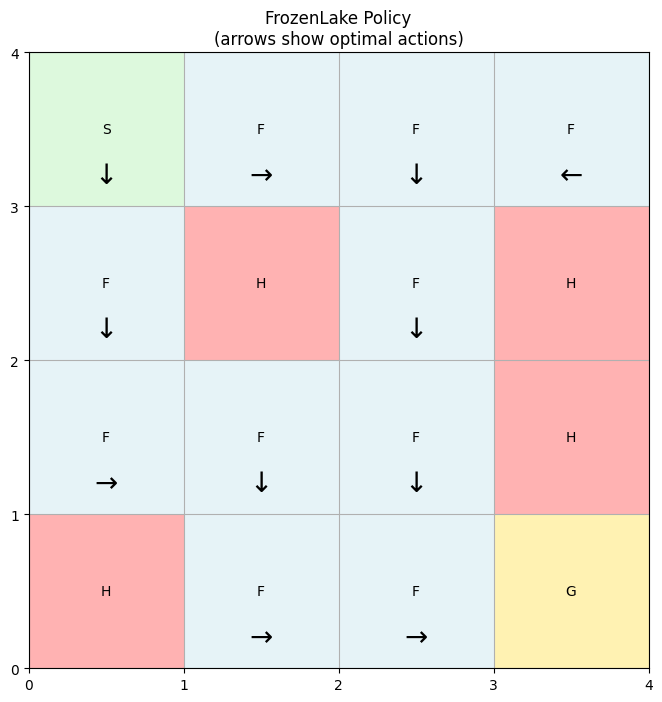

In [33]:
plot_policy(problem, solution.policy)

### 3.2 Slippery case

We can repeat the analysis for the slippery case, again comparing the results from MDPax and pymdptoolbox.

In [34]:
problem = FrozenLake(map_name="4x4", is_slippery=True)
solver = ValueIteration(problem, gamma=0.9, epsilon=1e-3)
solution = solver.solve()

2025-01-04 21:47:10.797 | INFO     | mdpax.core.solver:__init__:159 - Solver initialized with frozen_lake_4x4_slippery problem


2025-01-04 21:47:10.827 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:123 - Checkpointing not enabled
2025-01-04 21:47:11.128 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 1 span: 0.33333
2025-01-04 21:47:11.265 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 2 span: 0.10000
2025-01-04 21:47:11.271 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 3 span: 0.06000
2025-01-04 21:47:11.275 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 4 span: 0.05400
2025-01-04 21:47:11.279 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 5 span: 0.03510
2025-01-04 21:47:11.283 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 6 span: 0.02916
2025-01-04 21:47:11.286 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 7 span: 0.02066
2025-01-04 21:47:11.289 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 8 span: 0.01669
2025-01-04 21:47:11.292 | INFO     | mdpax.s

In [35]:
P, R = problem.build_transition_and_reward_matrices()
P, R = np.array(P), np.array(R)
vi = mdptoolbox.mdp.ValueIteration(P, R, discount=0.9, epsilon=1e-3)
vi.run()
print(f"MDPax and mdptoolbox policies match: {np.all(np.array(vi.policy) == solution.policy.flatten())}")

MDPax and mdptoolbox policies match: True


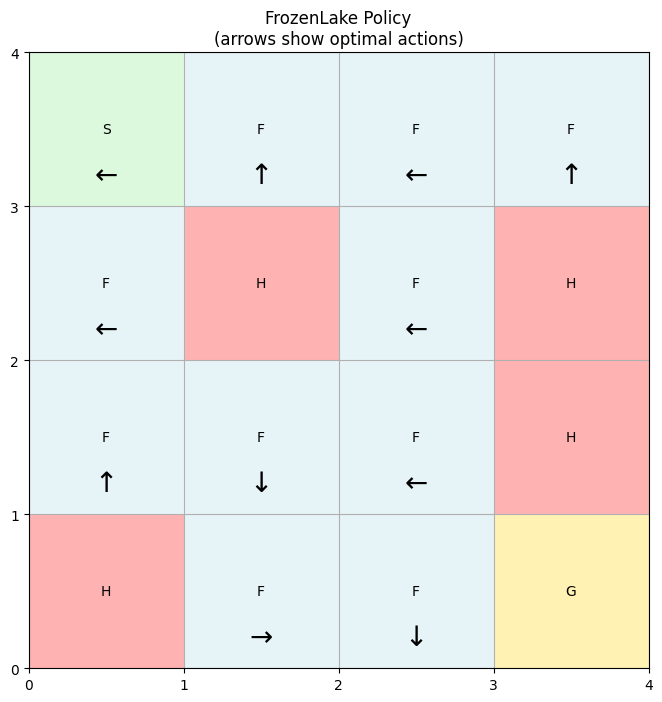

In [36]:
plot_policy(problem, solution.policy)

Note that even though this is the optimal policy, the agent won't always follow the arrows exactly when `is_slippery=True` because there's a chance of sliding left or right relative to the intended direction.

## Checkpoints for problems defined in notebooks

The checkpointing demonstration in [LINK TO DO OTHER NOTEBOOK] uses an MDPax example problem, which is defined in a Python module and has a [Hydra](https://hydra.cc/docs/1.3/intro/) configuration. This allows the use of the `restore` method which can recreate the problem and solver using the config.

If a problem is defined in a notebook, as is the case here, a lightweight version of checkpointing is enabled instead. It still saves the solver state, and so optimization can be resumed, but the user must manually recreate the problem and solver before loading the checkpoint, as shown below.

In [37]:
# Run the solver for 10 iterations
problem = FrozenLake(map_name="4x4", is_slippery=True)
solver = ValueIteration(problem, gamma=0.9, epsilon=1e-3, 
                        checkpoint_dir="initial_checkpoints", 
                        checkpoint_frequency=1)
solution = solver.solve(max_iterations = 10)

2025-01-04 21:47:12.334 | INFO     | mdpax.core.solver:__init__:159 - Solver initialized with frozen_lake_4x4_slippery problem
2025-01-04 21:47:12.370 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:147 - Lightweight checkpointing enabled - problem and solver must be reconstructed manually
2025-01-04 21:47:12.371 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:152 - Saving checkpoints every 1 iteration(s) to /home/joefarrington/other_learning/mdpax/examples/initial_checkpoints
2025-01-04 21:47:12.566 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 1 span: 0.33333
2025-01-04 21:47:12.749 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 2 span: 0.10000
2025-01-04 21:47:12.754 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 3 span: 0.06000
2025-01-04 21:47:12.759 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 4 span: 0.05400
2025-01-04 21:47:12.762 | INFO     | mdpax.solvers.value_iteration:solve:4

In [38]:
# load in the checkpoint and resume
problem_restored = FrozenLake(map_name="4x4", is_slippery=True)
solver_restored = ValueIteration(problem_restored, gamma=0.9, epsilon=1e-3, 
                                 checkpoint_dir="new_checkpoints", 
                                 checkpoint_frequency=1)
solver_restored.load_checkpoint(checkpoint_dir="initial_checkpoints")
solution_restored = solver_restored.solve(max_iterations = 100)

2025-01-04 21:47:13.053 | INFO     | mdpax.core.solver:__init__:159 - Solver initialized with frozen_lake_4x4_slippery problem
2025-01-04 21:47:13.089 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:147 - Lightweight checkpointing enabled - problem and solver must be reconstructed manually
2025-01-04 21:47:13.090 | INFO     | mdpax.utils.checkpointing:_setup_checkpointing:152 - Saving checkpoints every 1 iteration(s) to /home/joefarrington/other_learning/mdpax/examples/new_checkpoints
2025-01-04 21:47:13.356 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 11 span: 0.00806
2025-01-04 21:47:13.376 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 12 span: 0.00647
2025-01-04 21:47:13.381 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 13 span: 0.00547
2025-01-04 21:47:13.385 | INFO     | mdpax.solvers.value_iteration:solve:497 - Iteration 14 span: 0.00469
2025-01-04 21:47:13.389 | INFO     | mdpax.solvers.value_iteration:solve:4

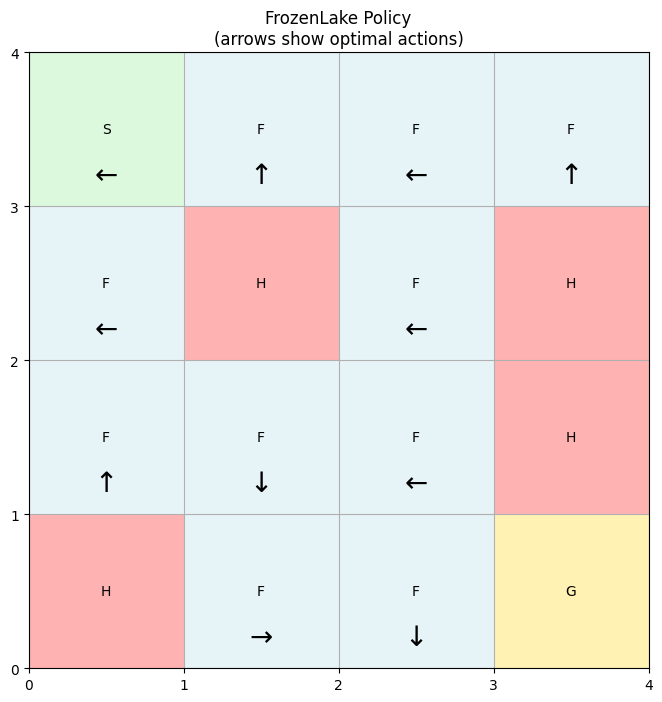

In [39]:
plot_policy(problem_restored, solution_restored.policy)

The plot shows the same policy as when we solved the same problem uninterrupted.

See [LINK TO FOREST] for a simple example of a problem defined in a module with a Hydra configuration.

## Next Steps

Try modifying the problem:
1. Create custom maps with different layouts
2. Modify the reward structure (e.g., small negative reward for each step)
3. Add new features like varying slipperiness or wind effects

For more examples and documentation:
- [MDPax Documentation](link)
- [Original FrozenLake Environment](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)